In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import statistics

In [6]:
df = pd.read_csv(f'./data/2015-2024_apiGameScores.csv')
df

,date,visitor,home,visitor_points,home_points
0,2015-11-24,Boston Celtics,Atlanta Hawks,97.0,121.0
1,2016-04-09,Boston Celtics,Atlanta Hawks,107.0,118.0
2,2016-04-16,Boston Celtics,Atlanta Hawks,101.0,102.0
3,2016-04-19,Boston Celtics,Atlanta Hawks,72.0,89.0
4,2016-04-26,Boston Celtics,Atlanta Hawks,83.0,110.0
...,...,...,...,...,...
12791,2020-02-28,Washington Wizards,Utah Jazz,119.0,129.0
12792,2021-04-12,Washington Wizards,Utah Jazz,125.0,121.0
12793,2021-12-18,Washington Wizards,Utah Jazz,109.0,103.0
12794,2022-12-22,Washington Wizards,Utah Jazz,112.0,120.0


In [7]:
# Take games between chosen years
start_year = 2018
current_year = dt.datetime.now().year

# Convert to datetime data type
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtered the dataframe for games between start year and current year
filtered_df = df[(df['date'].dt.year >= start_year) & (df['date'].dt.year <= current_year)]

# Reset data frame
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,date,visitor,home,visitor_points,home_points
0,2018-11-23,Boston Celtics,Atlanta Hawks,114.0,96.0
1,2019-01-19,Boston Celtics,Atlanta Hawks,113.0,105.0
2,2020-02-03,Boston Celtics,Atlanta Hawks,123.0,115.0
3,2021-02-24,Boston Celtics,Atlanta Hawks,112.0,127.0
4,2021-08-08,Boston Celtics,Atlanta Hawks,85.0,83.0
...,...,...,...,...,...
9282,2020-02-28,Washington Wizards,Utah Jazz,119.0,129.0
9283,2021-04-12,Washington Wizards,Utah Jazz,125.0,121.0
9284,2021-12-18,Washington Wizards,Utah Jazz,109.0,103.0
9285,2022-12-22,Washington Wizards,Utah Jazz,112.0,120.0


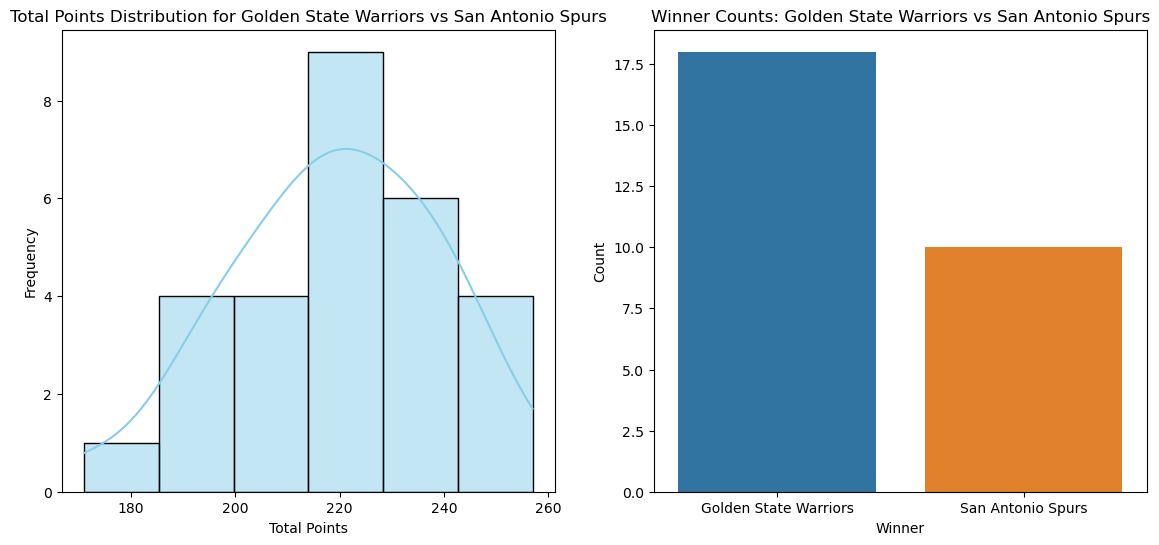

Statistics of Golden State Warriors vs San Antonio Spurs


Mean: 219.10714285714286
Standard Deviation: 19.894796054569397
------------------------------------
z-score for 190.5: -1.44
z-score for 191.5: -1.39
z-score for 192.5: -1.34
z-score for 193.5: -1.29
z-score for 194.5: -1.24
z-score for 195.5: -1.19
z-score for 196.5: -1.14
z-score for 197.5: -1.09
z-score for 198.5: -1.04
z-score for 199.5: -0.99
z-score for 200.5: -0.94
z-score for 201.5: -0.89
z-score for 202.5: -0.83
z-score for 203.5: -0.78
z-score for 204.5: -0.73
z-score for 205.5: -0.68
z-score for 206.5: -0.63
z-score for 207.5: -0.58
z-score for 208.5: -0.53
z-score for 209.5: -0.48


,date,visitor,home,visitor_points,home_points,total_points,winner
0,2018-02-10,San Antonio Spurs,Golden State Warriors,105.0,122.0,227.0,Golden State Warriors
1,2018-03-08,San Antonio Spurs,Golden State Warriors,107.0,110.0,217.0,Golden State Warriors
2,2018-04-14,San Antonio Spurs,Golden State Warriors,92.0,113.0,205.0,Golden State Warriors
3,2018-04-16,San Antonio Spurs,Golden State Warriors,101.0,116.0,217.0,Golden State Warriors
4,2018-04-19,Golden State Warriors,San Antonio Spurs,110.0,97.0,207.0,Golden State Warriors
5,2018-04-22,Golden State Warriors,San Antonio Spurs,90.0,103.0,193.0,San Antonio Spurs
6,2018-04-24,San Antonio Spurs,Golden State Warriors,91.0,99.0,190.0,Golden State Warriors
7,2018-11-18,Golden State Warriors,San Antonio Spurs,92.0,104.0,196.0,San Antonio Spurs
8,2019-02-06,San Antonio Spurs,Golden State Warriors,102.0,141.0,243.0,Golden State Warriors
9,2019-03-18,Golden State Warriors,San Antonio Spurs,105.0,111.0,216.0,San Antonio Spurs


In [17]:
def possible_outcome(dataframe, away_team, home_team, first_line): 
    # Filter the dataframe for the specific matchup
    matchup_game = dataframe.loc[
        ((dataframe['visitor'] == away_team) & (dataframe['home'] == home_team)) | 
        ((dataframe['visitor'] == home_team) & (dataframe['home'] == away_team))
        ].copy()
    
    # Add a 'total_points' column 
    matchup_game['total_points'] = matchup_game['visitor_points'] + matchup_game['home_points']
    
    # Sort by date
    matchup_game = matchup_game.sort_values(by='date').reset_index(drop=True)
    
    # Determine the winner
    matchup_game['winner'] = matchup_game.apply(
        lambda row: row['home'] if row['home_points'] > row['visitor_points'] else row['visitor'], 
        axis=1
    )
    
    # Filter out postponed games(with zero total points)
    matchup_game = matchup_game.loc[matchup_game['total_points'] != 0]


    # Calculate Q1, Q3 and IQR
    Q1 = matchup_game['total_points'].quantile(0.25)
    Q3 = matchup_game['total_points'].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter games where total points are not outliers
    # Create matches dataframe
    matches = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    matches = matches.reset_index(drop=True)
        
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
      
    # Plot total points distribution with a KDE
    sns.histplot(data=matches, x ='total_points', kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f'Total Points Distribution for {away_team} vs {home_team}')
    axes[0].set_xlabel('Total Points')
    axes[0].set_ylabel('Frequency')
    
    # Plot the winner count    
    sns.countplot(data=matches, x='winner', ax=axes[1], hue='winner')
    axes[1].set_title(f'Winner Counts: {away_team} vs {home_team}')
    axes[1].set_xlabel('Winner')
    axes[1].set_ylabel('Count')
        
    # Display the plots
    plt.show()
    
     # Calculate a z-score from a provided mean and standard deviation
    mean = matches['total_points'].mean()
    standard_deviation = matches['total_points'].std()
   
    # Create array of UNDER/OVER values based first line
    under_over_lines = [first_line + i for i in range(-10, 10)]
    
    # Display basic statics of team matchup
    print(f'Statistics of {away_team} vs {home_team}')
    print('\n')
    print(f'Mean: {mean}')
    print(f'Standard Deviation: {standard_deviation}')

    print('------------------------------------')
    # Display the z-scores for each line score
    for line in under_over_lines:
        zscore = statistics.NormalDist(mean, standard_deviation).zscore(line)
        print(f'z-score for {line}: {zscore:.2f}')

    # print('------------------------------------')

    # Find percentage of games between specified range
    # total_games = len(matchup_game)
    # games_in_range = matchup_game[(matchup_game['total_points'] >= lower_bound) & (matchup_game['total_points'] <= upper_bound)]
    # percentage = (len(games_in_range) / total_games) * 100
    # print(f"Percentage of games with total scores between {lower_bound} and {upper_bound}: {percentage:.2f}%")
    # print('------------------------------------')
    
    return matches

away_team = input("Enter the away team: ")
home_team = input("Enter the home team: ")
first_line = float(input("Enter the first line for the over/under bet: "))


possible_outcome(filtered_df, away_team, home_team, first_line)

In [9]:
teams = df['visitor'].unique()
teams.sort()
teams

array(['Atlanta Hawks', 'Boston Celtics', 'Brooklyn Nets',
       'Charlotte Hornets', 'Chicago Bulls', 'Cleveland Cavaliers',
       'Dallas Mavericks', 'Denver Nuggets', 'Detroit Pistons',
       'Golden State Warriors', 'Houston Rockets', 'Indiana Pacers',
       'LA Clippers', 'Los Angeles Lakers', 'Memphis Grizzlies',
       'Miami Heat', 'Milwaukee Bucks', 'Minnesota Timberwolves',
       'New Orleans Pelicans', 'New York Knicks', 'Oklahoma City Thunder',
       'Orlando Magic', 'Philadelphia 76ers', 'Phoenix Suns',
       'Portland Trail Blazers', 'Sacramento Kings', 'San Antonio Spurs',
       'Toronto Raptors', 'Utah Jazz', 'Washington Wizards'], dtype=object)